In [1]:
!pip install -U classiq pydantic -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.9/387.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

In [2]:
!pip show classiq

Name: classiq
Version: 0.43.2
Summary: Classiq's Python SDK for quantum computing
Home-page: https://classiq.io
Author: Classiq Technologies
Author-email: support@classiq.io
License: Proprietary
Location: /usr/local/lib/python3.10/dist-packages
Requires: black, ConfigArgParse, httpx, keyring, matplotlib, networkx, numexpr, numpy, packaging, pandas, plotly, pydantic, Pyomo, scipy, sympy, tabulate
Required-by: 


## Quantum Walk:
   - This implements a discrete-time quantum walk on a line with 16 nodes.
   - The walk consists of two main parts: the coin flip (W_operator) and the shift (S_operator).
   
## Some Variables and Functions:
1. Coin Flip (W_operator):
   - For each node, it creates a superposition of moving left or right (or just one direction for end nodes).
   - This is analogous to flipping a coin in a classical random walk.

2. Shift (S_operator):
   - Swaps the amplitudes between adjacent nodes based on the edge structure of the line.

3. Graph Structure:
   - The line structure is encoded in both the W_iteration function (defining allowed moves) and the edge_oracle function (defining adjacency).

4. Quantum Registers:
   - 'vertices' register: Represents the current position.
   - 'adjacent_vertices' register: Used to create superpositions of adjacent states.

### The Graph we want to apply quantum walk on:
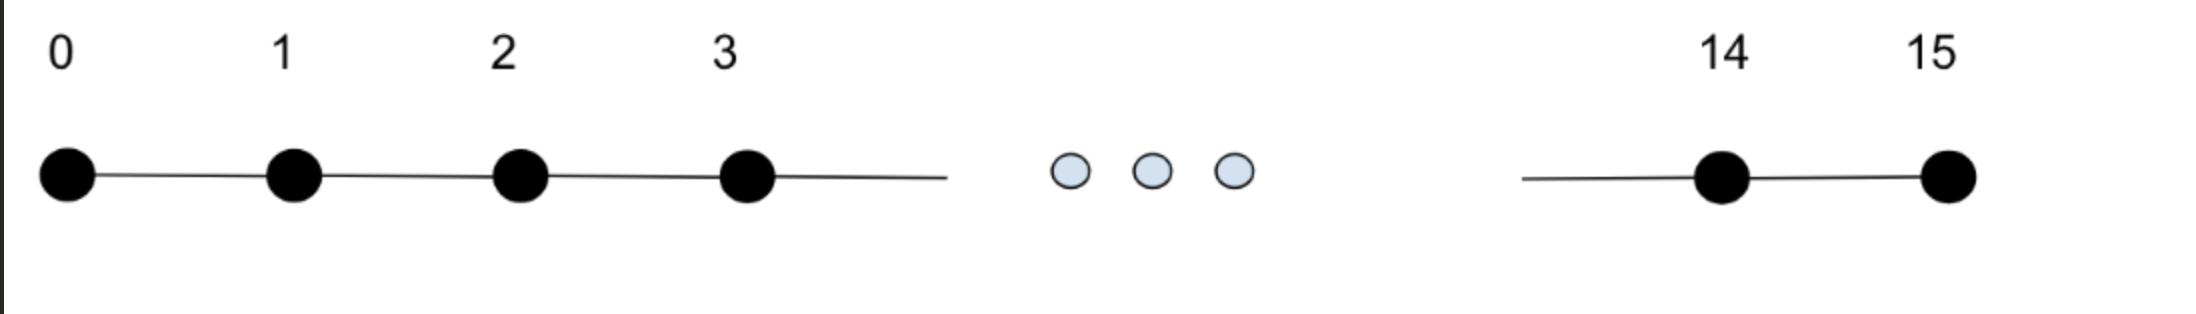

I performed some modifications to the code given in the problem statement so that it is compatible with the given problem statement.

The changes are as follows:
- set `size=4`
- generalized all hardcoded numbers according to size variable
- Changed the oracle for this graph, it is such that the absolute difference between edges is 1:
    * ```python
    @qfunc
    def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
        res |= (((vertices-adjacent_vertices) == 1)  | ((vertices-adjacent_vertices) == -1))
    ```
- Changed the prob array initialization in W_iteration function:
    * ```python
    prob = [0] * (2**size)  # Initialize probabilities for all states
    if(i==0):
        prob[1]=1 # 0 is conneted with only 1 so thats the only possible path
    elif i==2**size-1:
        prob[2**size-2]=1 # 15 is conneted with only 14 so thats the only possible path
    else:
        prob[(i-1)%(2**size)] = 0.5  # Probability to move left (one step back)
        prob[(i+1) % (2**size)] = 0.5  # Probability to move right (one step forward)
        ```

In [3]:
from classiq import *
import numpy as np

In [4]:
authenticate(overwrite=True)

Your user code: QXMS-QWFH
If a browser doesn't automatically open, please visit this URL from any trusted device: https://auth.classiq.io/activate?user_code=QXMS-QWFH


In [5]:
size = 4

@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int, vertices: QNum, adjacent_vertices: QNum):
    prob = [0] * (2**size)  # Initialize probabilities for all states
    if(i==0):
        prob[1]=1 # 0 is conneted with only 1 so thats the only possible path
    elif i==2**size-1:
        prob[2**size-2]=1
    else:
        prob[(i-1)%(2**size)] = 0.5  # Probability to move left (one step back)
        prob[(i+1) % (2**size)] = 0.5  # Probability to move right (one step forward)

    print(f'State={i}, prob vec ={prob}')

    control(ctrl=vertices==i,
            operand=lambda: within_apply(
                compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
                action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
        W_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices-adjacent_vertices) == 1)  | ((vertices-adjacent_vertices) == -1))


@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    repeat(count= x.len,
        iteration= lambda i: SWAP(x[i],y[i]))


@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
            operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

    allocate(size,vertices)
    hadamard_transform(vertices)
    allocate(size,adjacent_vertices)

    W_operator(vertices,adjacent_vertices)
    S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)


State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

Circuit is as follows: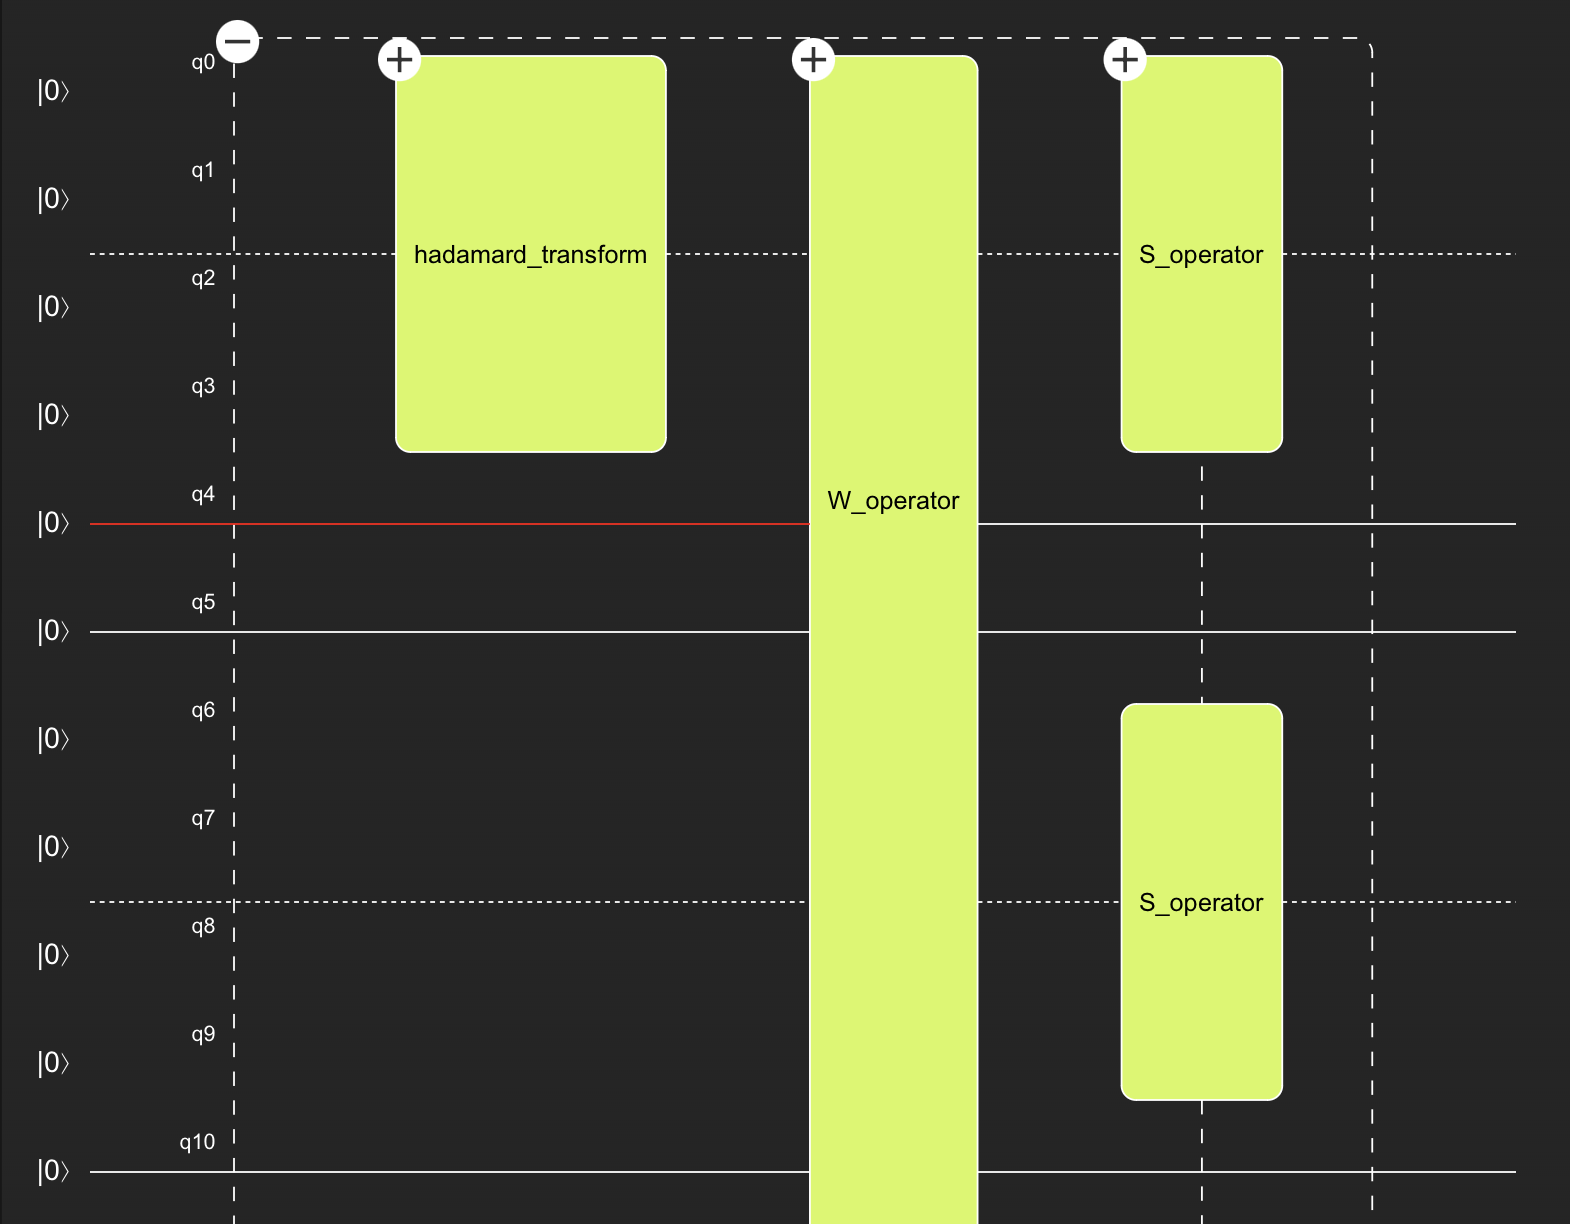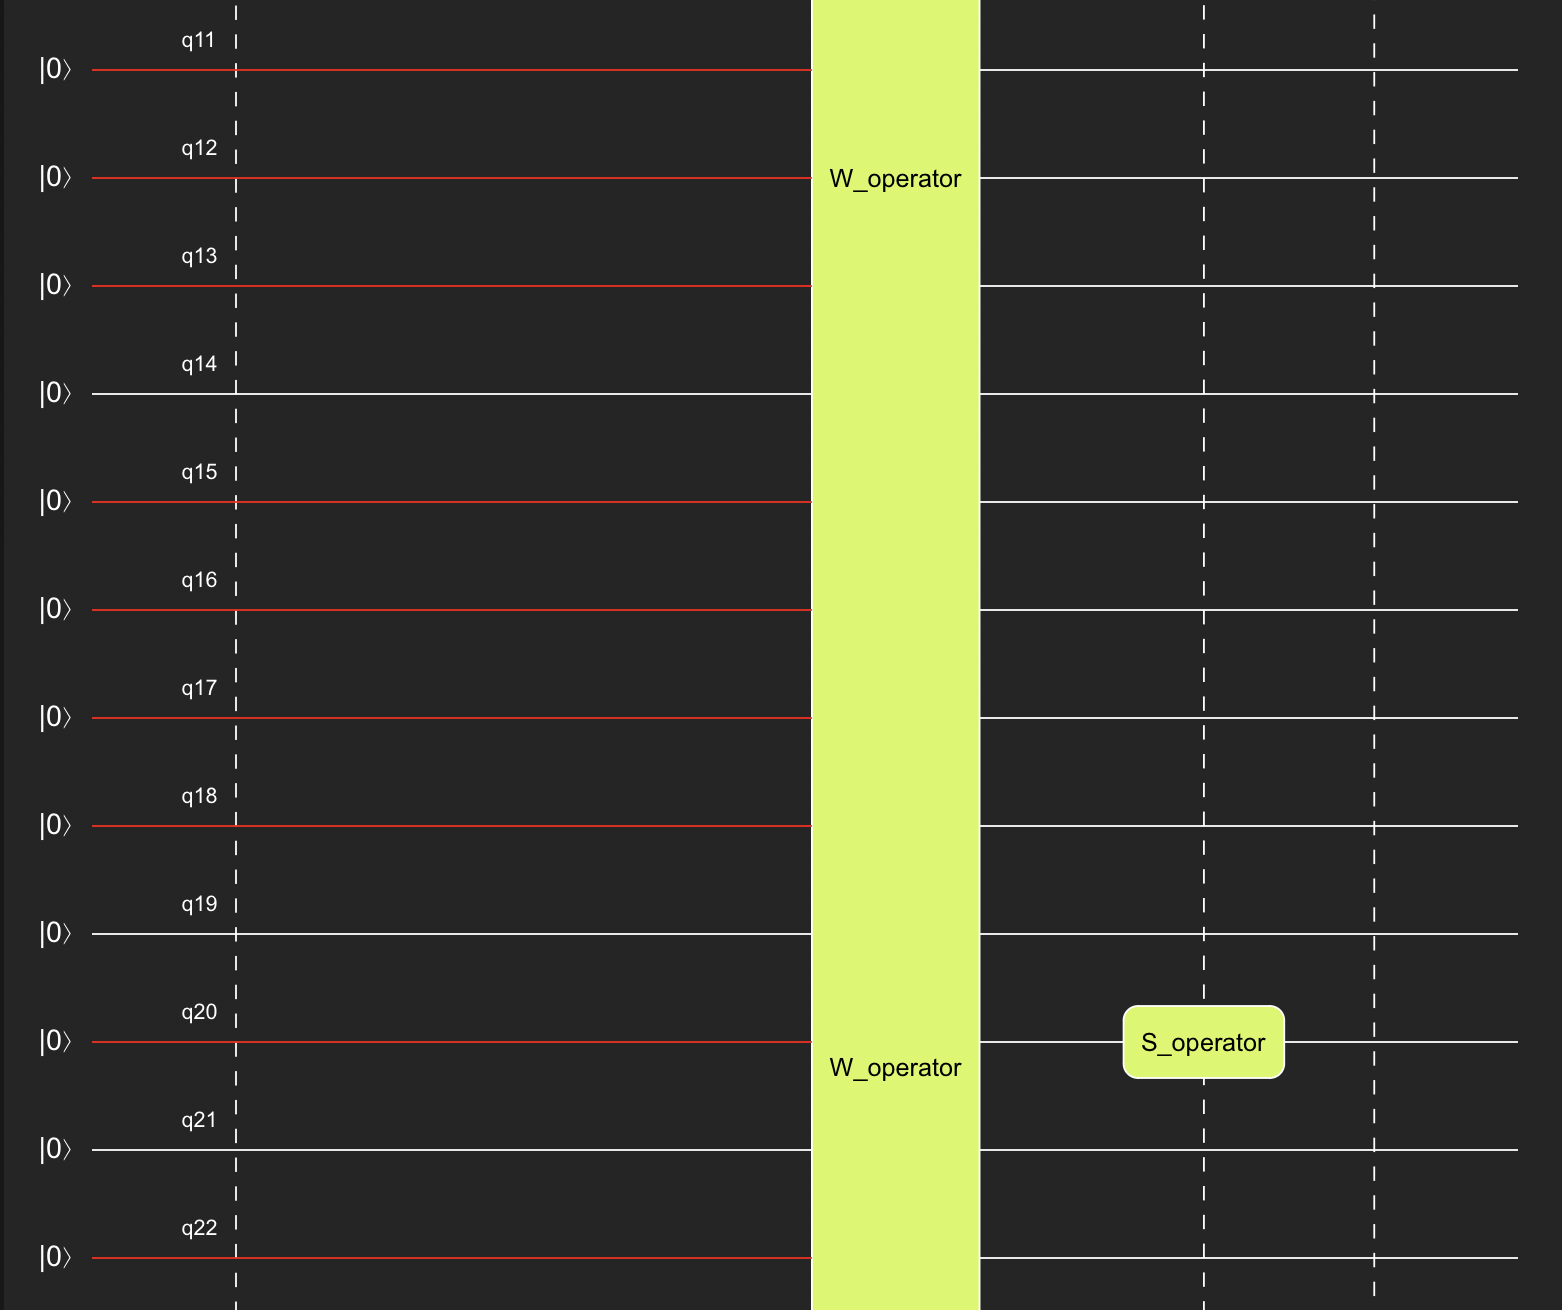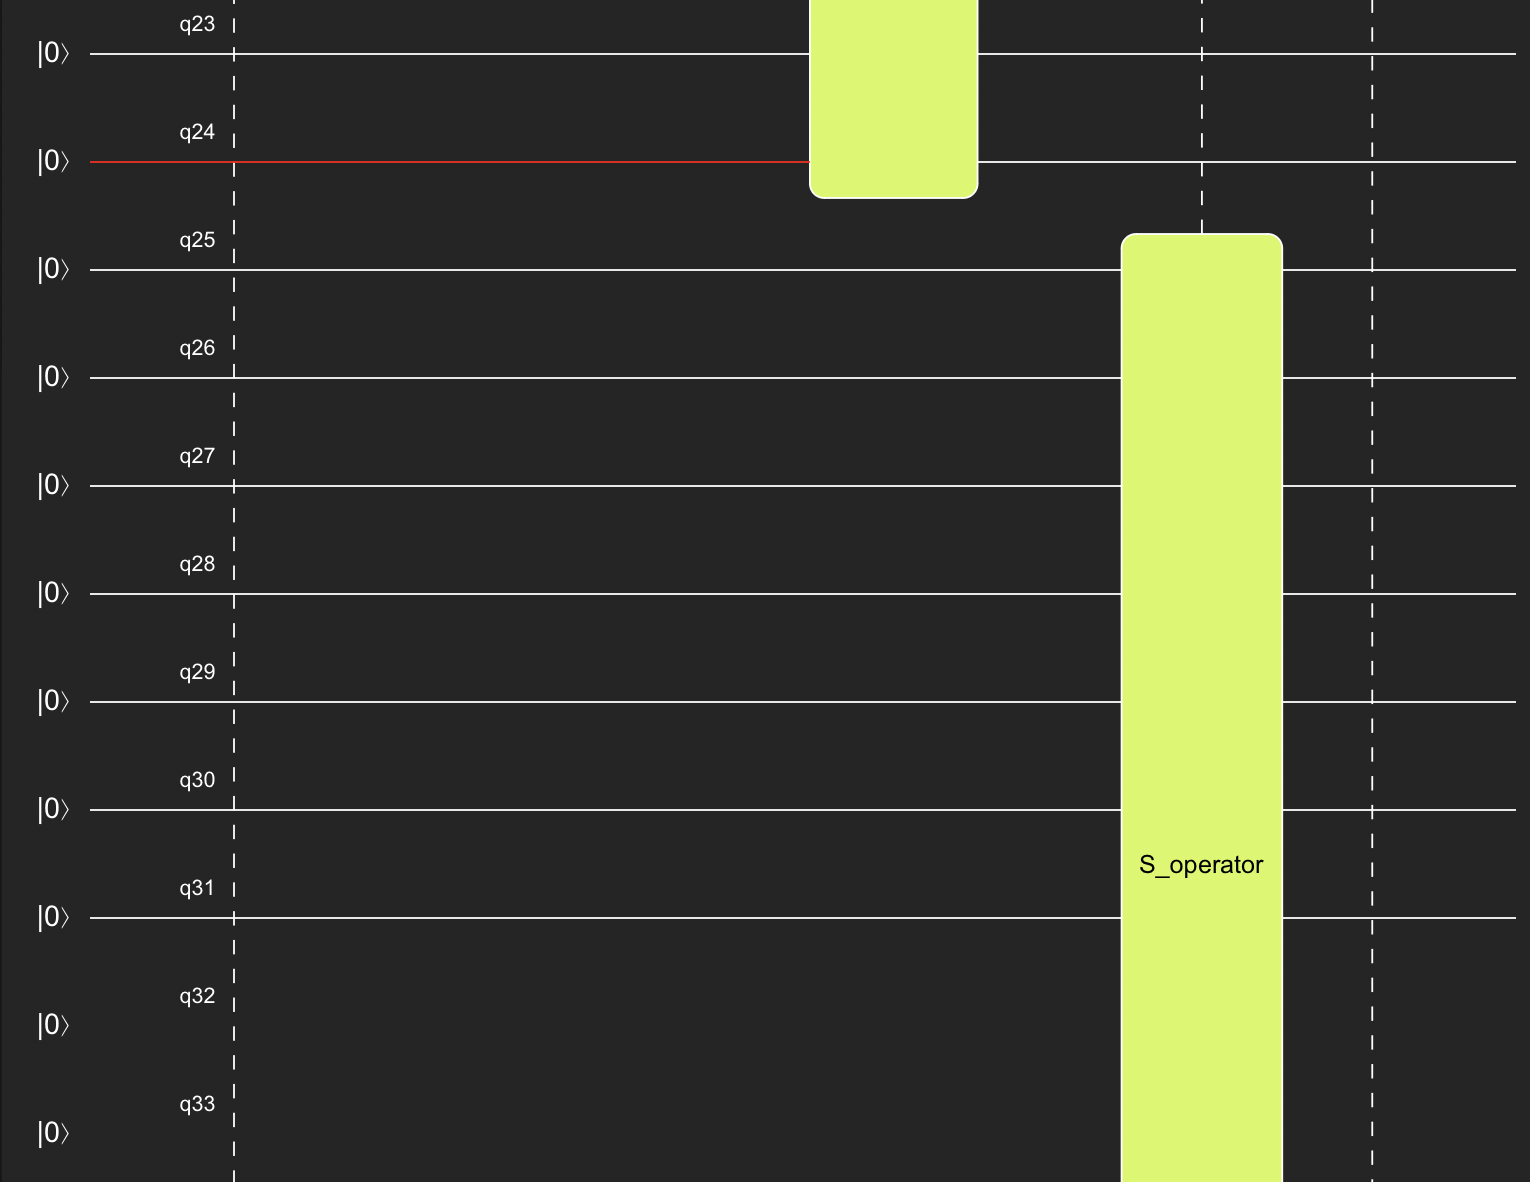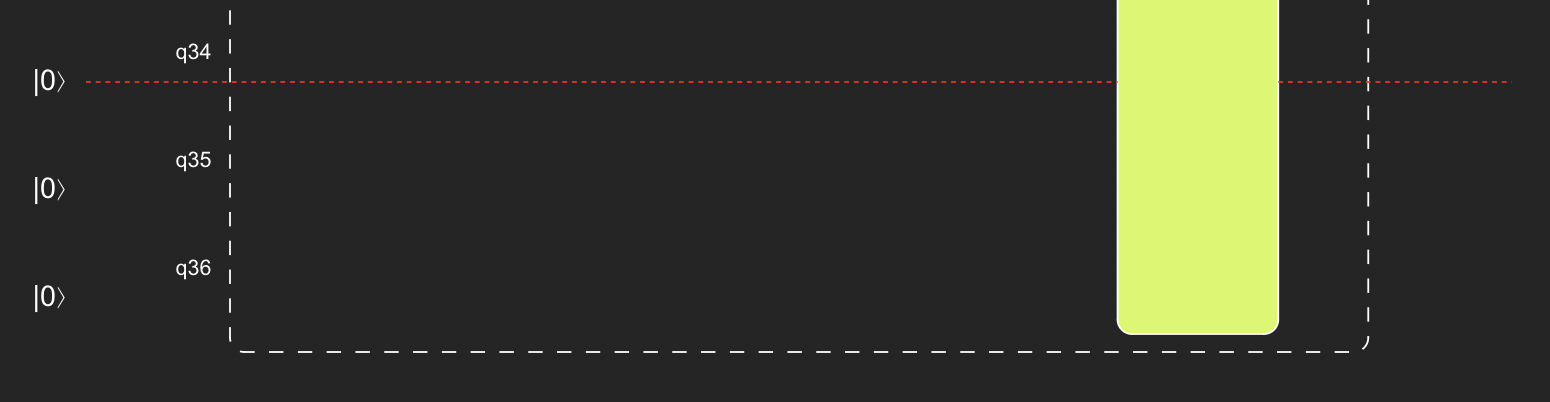

In [7]:
write_qmod(qmod, "6_12")

## QMOD Code below:
```python
qfunc prepare_minus(x: qbit) {
  X(x);
  H(x);
}

qfunc zero_diffuzer(x: qnum) {
  aux: qnum;
  allocate<1>(aux);
  within {
    prepare_minus(aux);
  } apply {
  }
}

qfunc W_operator(vertices: qnum, adjacent_vertices: qnum) {
  control (vertices == 0) {
    within {
      inplace_prepare_state<[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
  control (vertices == 1) {
    within {
      inplace_prepare_state<[
        0.5,
        0,
        0.5,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0
      ], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
  control (vertices == 2) {
    within {
      inplace_prepare_state<[
        0,
        0.5,
        0,
        0.5,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0
      ], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
  control (vertices == 3) {
    within {
      inplace_prepare_state<[
        0,
        0,
        0.5,
        0,
        0.5,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0
      ], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
  control (vertices == 4) {
    within {
      inplace_prepare_state<[
        0,
        0,
        0,
        0.5,
        0,
        0.5,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0
      ], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
  control (vertices == 5) {
    within {
      inplace_prepare_state<[
        0,
        0,
        0,
        0,
        0.5,
        0,
        0.5,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0
      ], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
  control (vertices == 6) {
    within {
      inplace_prepare_state<[
        0,
        0,
        0,
        0,
        0,
        0.5,
        0,
        0.5,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0
      ], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
  control (vertices == 7) {
    within {
      inplace_prepare_state<[
        0,
        0,
        0,
        0,
        0,
        0,
        0.5,
        0,
        0.5,
        0,
        0,
        0,
        0,
        0,
        0,
        0
      ], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
  control (vertices == 8) {
    within {
      inplace_prepare_state<[
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0.5,
        0,
        0.5,
        0,
        0,
        0,
        0,
        0,
        0
      ], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
  control (vertices == 9) {
    within {
      inplace_prepare_state<[
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0.5,
        0,
        0.5,
        0,
        0,
        0,
        0,
        0
      ], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
  control (vertices == 10) {
    within {
      inplace_prepare_state<[
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0.5,
        0,
        0.5,
        0,
        0,
        0,
        0
      ], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
  control (vertices == 11) {
    within {
      inplace_prepare_state<[
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0.5,
        0,
        0.5,
        0,
        0,
        0
      ], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
  control (vertices == 12) {
    within {
      inplace_prepare_state<[
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0.5,
        0,
        0.5,
        0,
        0
      ], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
  control (vertices == 13) {
    within {
      inplace_prepare_state<[
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0.5,
        0,
        0.5,
        0
      ], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
  control (vertices == 14) {
    within {
      inplace_prepare_state<[
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0.5,
        0,
        0.5
      ], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
  control (vertices == 15) {
    within {
      inplace_prepare_state<[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 0.01>(adjacent_vertices);
    } apply {
      zero_diffuzer(adjacent_vertices);
    }
  }
}

qfunc edge_oracle(output res: qbit, vertices: qnum, adjacent_vertices: qnum) {
  res = ((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == (-1));
}

qfunc bitwise_swap(x: qbit[], y: qbit[]) {
  repeat (i: x.len) {
    SWAP(x[i], y[i]);
  }
}

qfunc S_operator(vertices: qnum, adjacent_vertices: qnum) {
  res: qnum;
  edge_oracle(res, vertices, adjacent_vertices);
  control (res == 1) {
    bitwise_swap(vertices, adjacent_vertices);
  }
}

qfunc main(output vertices: qnum, output adjacent_vertices: qnum) {
  allocate<4>(vertices);
  hadamard_transform(vertices);
  allocate<4>(adjacent_vertices);
  W_operator(vertices, adjacent_vertices);
  S_operator(vertices, adjacent_vertices);
}


```